# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [1]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

## Parameters

In [2]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'Xception'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

## Initialization

In [4]:
print('='*20)
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
print('='*20)
net = getattr(fornet,net_model)().eval().to(device)
print('='*20)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to C:\Users\Justin/.cache\torch\checkpoints\xception-43020ad28.pth


  0%|          | 0.00/87.4M [00:00<?, ?B/s]

Downloading: "https://f002.backblazeb2.com/file/icpr2020/Xception_DFDC_bestval-e826cdb64d73ef491e6b8ff8fce0e1e1b7fc1d8e2715bc51a56280fff17596f9.pth" to C:\Users\Justin/.cache\torch\checkpoints\Xception_DFDC_bestval-e826cdb64d73ef491e6b8ff8fce0e1e1b7fc1d8e2715bc51a56280fff17596f9.pth


  0%|          | 0.00/39.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [5]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [6]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

## Detect faces

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.cuda.current_device()

0

In [9]:
torch.cuda.device(0)

In [10]:
torch.cuda.device_count()

1

In [11]:
torch.cuda.get_device_name(0)

'GeForce RTX 3080'

In [12]:
vid_real_faces = face_extractor.process_video('samples/lynaeydofd.mp4')
vid_fake_faces = face_extractor.process_video('samples/mqzvfufzoq.mp4')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [13]:
im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

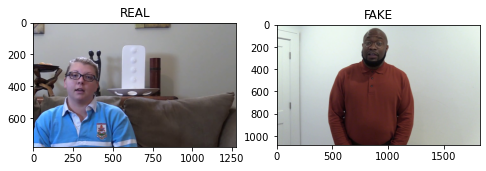

In [14]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores for each frame

In [15]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

C:\Users\Justin\anaconda3\envs\icpr2020\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


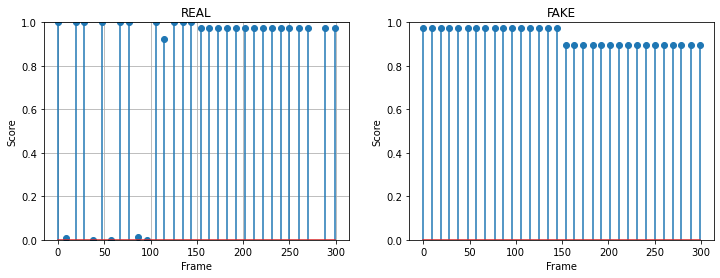

In [16]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [17]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 1.0000
Average score for FAKE face: 0.9456
